In [1]:
import tensorflow as tf

from zipfile import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Loading the dataset
from fileinput import filename


link = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
file_path = tf.keras.utils.get_file(origin=link, fname="jena_climate_2009_2016.csv.zip")
zipping_file = ZipFile(file_path)
zipping_file.extractall()
data_1 = "jena_climate_2009_2016.csv"
import pandas as pd
dataframe = pd.read_csv(r"jena_climate_2009_2016.csv")

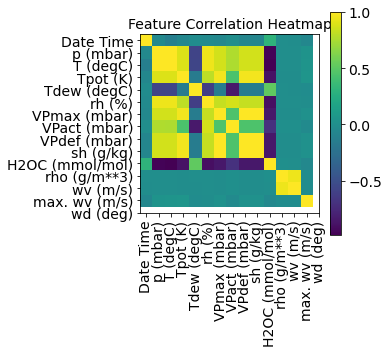

In [3]:
#check correlation between the features
def heatmap(data_1):
    plt.matshow(data_1.corr())
    plt.xticks(range(data_1.shape[1]), data_1.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data_1.shape[1]), data_1.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


heatmap(dataframe)

In [4]:
split_fraction = 0.715
train_split = int(split_fraction * int(dataframe.shape[0]))
step = 6

past = 720
future = 72

#batch_size = 256
#epochs = 3

In [5]:
#scaling of the data

def normalize(data_1, train_split):
    mean = data_1[:train_split].mean(axis=0)
    std = data_1[:train_split].std(axis=0)
    return (data_1 - mean) / std


In [6]:
#extracting the mean and std deviation of the train_dataset
def meanstd(data_1, train_split):
    mean = data_1[:train_split].mean(axis=0)
    std = data_1[:train_split].std(axis=0)
    return mean, std

In [7]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]


date_time_key = "Date Time"

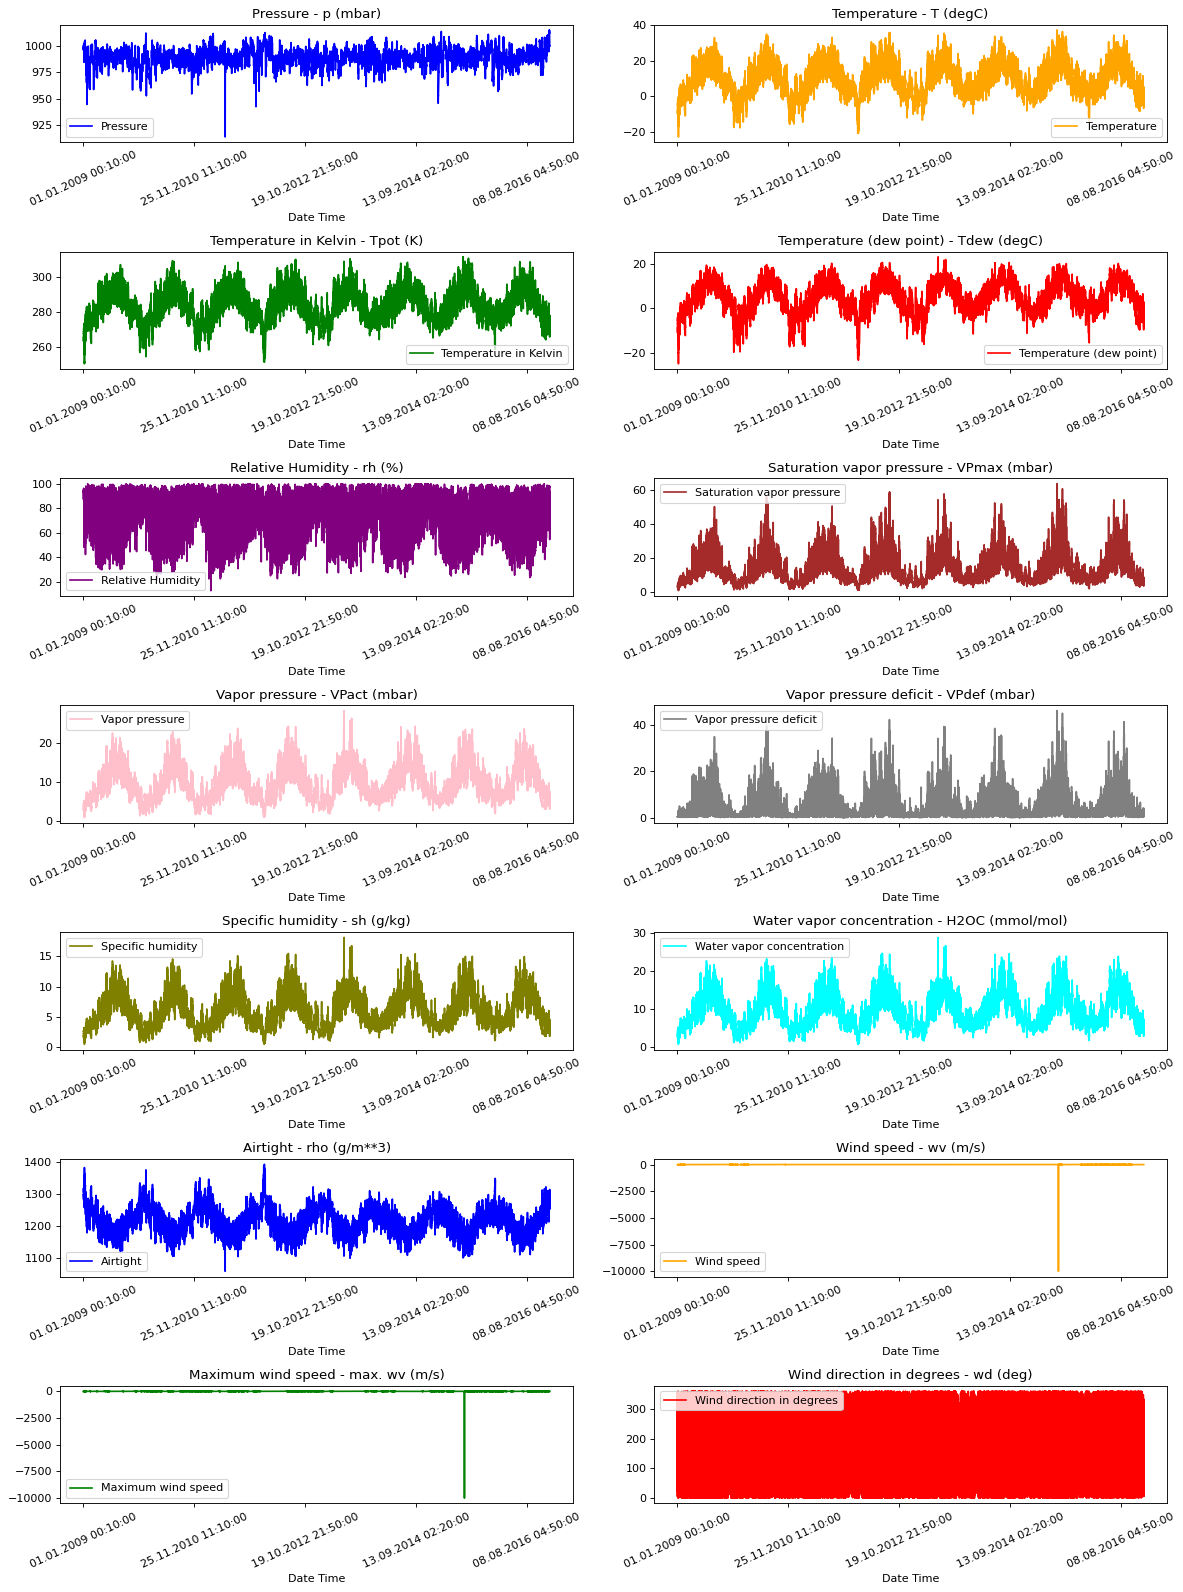

In [8]:
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]





def raw_visualization(data_1):
    time_data = data_1[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data_1[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


raw_visualization(dataframe)

In [9]:

print(
    "The parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

#selection of the features that aren't correlated 
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = dataframe[selected_features]
features.index = dataframe[date_time_key]
features.head()


m, std = meanstd(features.values, train_split)


#scaling features
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

#define train and val data with split defined
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [10]:
#The training dataset labels starts from the 792nd observation (720 + 72).
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

#making a keras timeseries dataset
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=256,
)

In [11]:
#The validation dataset must not contain the last 792 rows as we won't have label data for those records, hence 792 must be subtracted from the end of the data.
#The validation label dataset must start from 792 after train_split, hence we must add past + future (792) to label_start.

x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]


#making a keras timeseries dataset
dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=256,
)

In [12]:
data_x = pd.DataFrame(x_val)
data_y = pd.DataFrame(y_val)

#saving the validation dataset as we would need it in our prediction file 
data_x.to_csv(r"ValFeatures.csv",index=False)
data_y.to_csv(r"ValLabels.csv",index=False)


In [13]:
for batch in dataset_train.take(1):
    inputs, targets = batch

In [14]:
#defining the model

inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [15]:
#model fitting

path_checkpoint = "model_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
monitor="val_loss",
filepath=path_checkpoint,
verbose=1,
save_weights_only=True,
save_best_only=True,metrics=['mean_absolute_error']
)
model.compile(optimizer="adam", loss="mse", metrics=["mean_squared_error", "mean_absolute_error"])

history = model.fit(
dataset_train,
epochs=2,
validation_data=dataset_val,
callbacks=[es_callback, modelckpt_callback],
)

print(history.history['mean_absolute_error'])

Epoch 1/2
1172/1172 [==============================] - ETA: 0s - loss: 0.1864 - mean_squared_error: 0.1864 - mean_absolute_error: 0.3304
Epoch 00001: val_loss improved from inf to 0.15616, saving model to model_checkpoint.h5
1172/1172 [==============================] - 127s 106ms/step - loss: 0.1864 - mean_squared_error: 0.1864 - mean_absolute_error: 0.3304 - val_loss: 0.1562 - val_mean_squared_error: 0.1562 - val_mean_absolute_error: 0.3107
Epoch 2/2
1172/1172 [==============================] - ETA: 0s - loss: 0.1235 - mean_squared_error: 0.1235 - mean_absolute_error: 0.2731
Epoch 00002: val_loss improved from 0.15616 to 0.15328, saving model to model_checkpoint.h5
1172/1172 [==============================] - 116s 99ms/step - loss: 0.1235 - mean_squared_error: 0.1235 - mean_absolute_error: 0.2731 - val_loss: 0.1533 - val_mean_squared_error: 0.1533 - val_mean_absolute_error: 0.3059
[0.33037281036376953, 0.27305400371551514]


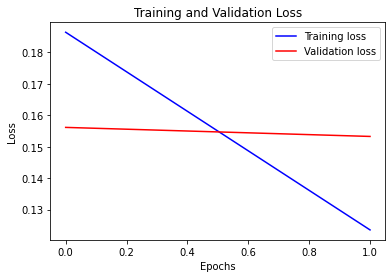

In [16]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

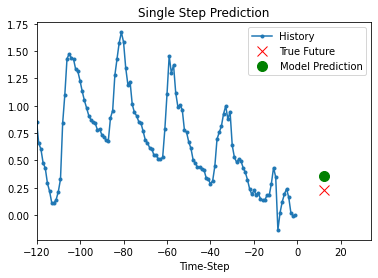

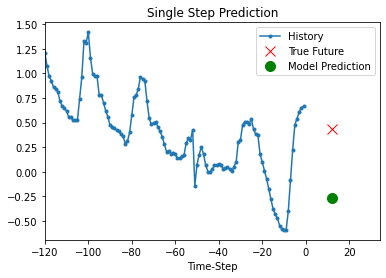

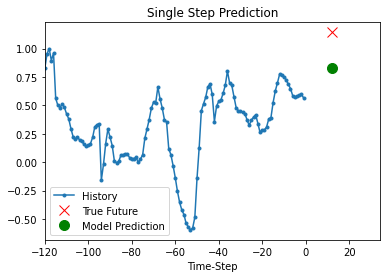

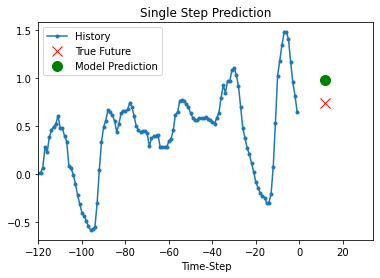

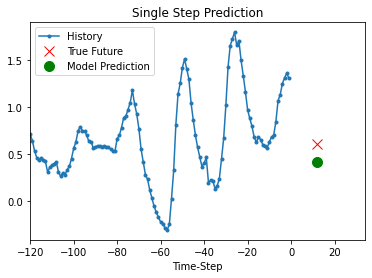

In [17]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [18]:
#saving the model and push the model to git for using later
model.save(r"model.h5")

In [19]:
#define the number of future steps or hours you need the prediction for
stps = 5

In [20]:
pred=[]
from tqdm import tqdm
#The trained model will now be able to make predictions for 5 sets of values from validation.
for x, y in tqdm(dataset_val.take(int(stps))):
       pred.append((model.predict(x)[0])*8.635 + 9.25)
     


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]
